In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import math
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Ignore error message.
pd.options.mode.chained_assignment = None  # default='warn'

### Helper functions

In [3]:
def convert_date(mls):	
	'''Function to convert a date given in milliseconds into a timestamp.'''
 
	return datetime.datetime.utcfromtimestamp(mls)

In [4]:
def convert_station_id(id):
    '''Function to convert a station ID to a station name.'''
    
    # Data frame containing station ID and corresponding station name.
    stationID_to_stationName = pd.read_csv('./general_data/sprottenflotte_map_stationID_to_stationName.csv').set_index('Station_ID')

    # Dictionary that maps the station ID to the corresponding station name.
    station_id_dict = stationID_to_stationName.to_dict()
    # Dictionary entry for the average values.
    station_id_dict['name'][99999] = 'Average'

    return station_id_dict['name'][id]

In [5]:
# Retrieve a dictionary to map the station id to the corresponding location.
station_info = pd.read_csv('./general_data/sprottenflotte_station_information.csv')[['Station_ID', 'lat', 'lon', 'name']].set_index('Station_ID')
station_info_dict = station_info.to_dict()


### Visualize the average day per station and the average day of all stations

In [6]:
# Load the data and convert the dates given in milliseconds into timestamps.
sf_df = pd.read_csv('./data/sprottenflotte_data.csv')[['Station_ID', 'Number_of_Bikes', 'last_update', 'last_reported']]
sf_df['last_update'] = sf_df['last_update'].apply(convert_date)
sf_df

Station_ID  Number_of_Bikes         last_update  last_reported
0            24371               23 2023-03-03 00:10:53     1677792158
1            24464               18 2023-03-03 00:10:53     1677781956
2            24384                0 2023-03-03 00:10:53     1677777220
3            24424               17 2023-03-03 00:10:53     1677795538
4            24468                2 2023-03-03 00:10:53     1677687849
...            ...              ...                 ...            ...
560952       24465                0 2023-03-19 16:45:09     1679223257
560953       24467                2 2023-03-19 16:45:09     1679236892
560954       24396                0 2023-03-19 16:45:09     1679209540
560955       24457                0 2023-03-19 16:45:09     1679236983
560956       24416               11 2023-03-19 16:45:09     1679221396

[560957 rows x 4 columns]

In [7]:
# The stations we look at.
all_stations = sf_df['Station_ID'].unique()
# Filter the stations of Kiel.
stations_in_kiel = list(filter(lambda x : station_info_dict['lon'][x] > 10.0 and station_info_dict['lon'][x] < 10.26, all_stations))
stations = stations_in_kiel

In [8]:
def get_avg_usage_of_all_days():
    '''Return a list containing the average number of used bikes per station for each hour of all days.'''
    
    # The resulting list.
    usage_of_station_per_hour = []

    # The days we look at.
    days = []
    for date in sf_df['last_update']:
        day = date.day
        if day not in days:
            days.append(day)
    # The number of days we look at.
    number_of_days = len(days)
    
    # Add overall average of used bikes.
    for hour in range(24):
        # Select data for each hour.
        selected_date_df = sf_df.loc[sf_df['last_update'].apply(lambda x : x.hour == hour)]
        reported = selected_date_df['last_reported'].unique()
        usage_of_station_per_hour_dict = {'Station_ID': 99999, 'Hour': hour, 'Used Bikes': ((len(reported) - len(stations_in_kiel)) / number_of_days) / len(stations_in_kiel)}
        usage_of_station_per_hour.append(usage_of_station_per_hour_dict)
    
    # Add used bikes average for every station and every hour.
    for id in stations:
        for hour in range(24):
            # Select data for each hour.
            selected_date_df = sf_df.loc[sf_df['last_update'].apply(lambda x : x.hour == hour)]
            # Select data for each station.
            reported = selected_date_df.query(f"Station_ID == {id}")['last_reported'].unique()
            usage_of_station_per_hour_dict = {'Station_ID': id, 'Hour': hour, 'Used Bikes': (len(reported) - 1) / number_of_days}
            usage_of_station_per_hour.append(usage_of_station_per_hour_dict)
            
    return usage_of_station_per_hour

##### Only uncomment next two cells for new calculations (takes time)

In [9]:
# Create a dataframe from the above list of dictionaries.
# hour_avg_usage_df = pd.DataFrame(get_avg_usage_of_all_days())

In [10]:
#  Convert the station ID into the station name.
# hour_avg_usage_df['Station_ID'] = hour_avg_usage_df['Station_ID'].apply(convert_station_id)
# hour_avg_usage_df

##### Save or load the data frame in case of new calculations

In [11]:
# Save the daily usage as csv for further calculations.
# hour_avg_usage_df.to_csv('./general_data/daily_usage.csv', index=False)

# Load the daily usage from the saved csv file.
hour_avg_usage_df = pd.read_csv('./general_data/daily_usage.csv')

In [12]:
# Normalize the 'Used Bikes' column.
scaler = MinMaxScaler()
hour_avg_usage_df['Used Bikes'] = (scaler.fit_transform(hour_avg_usage_df[['Used Bikes']]))

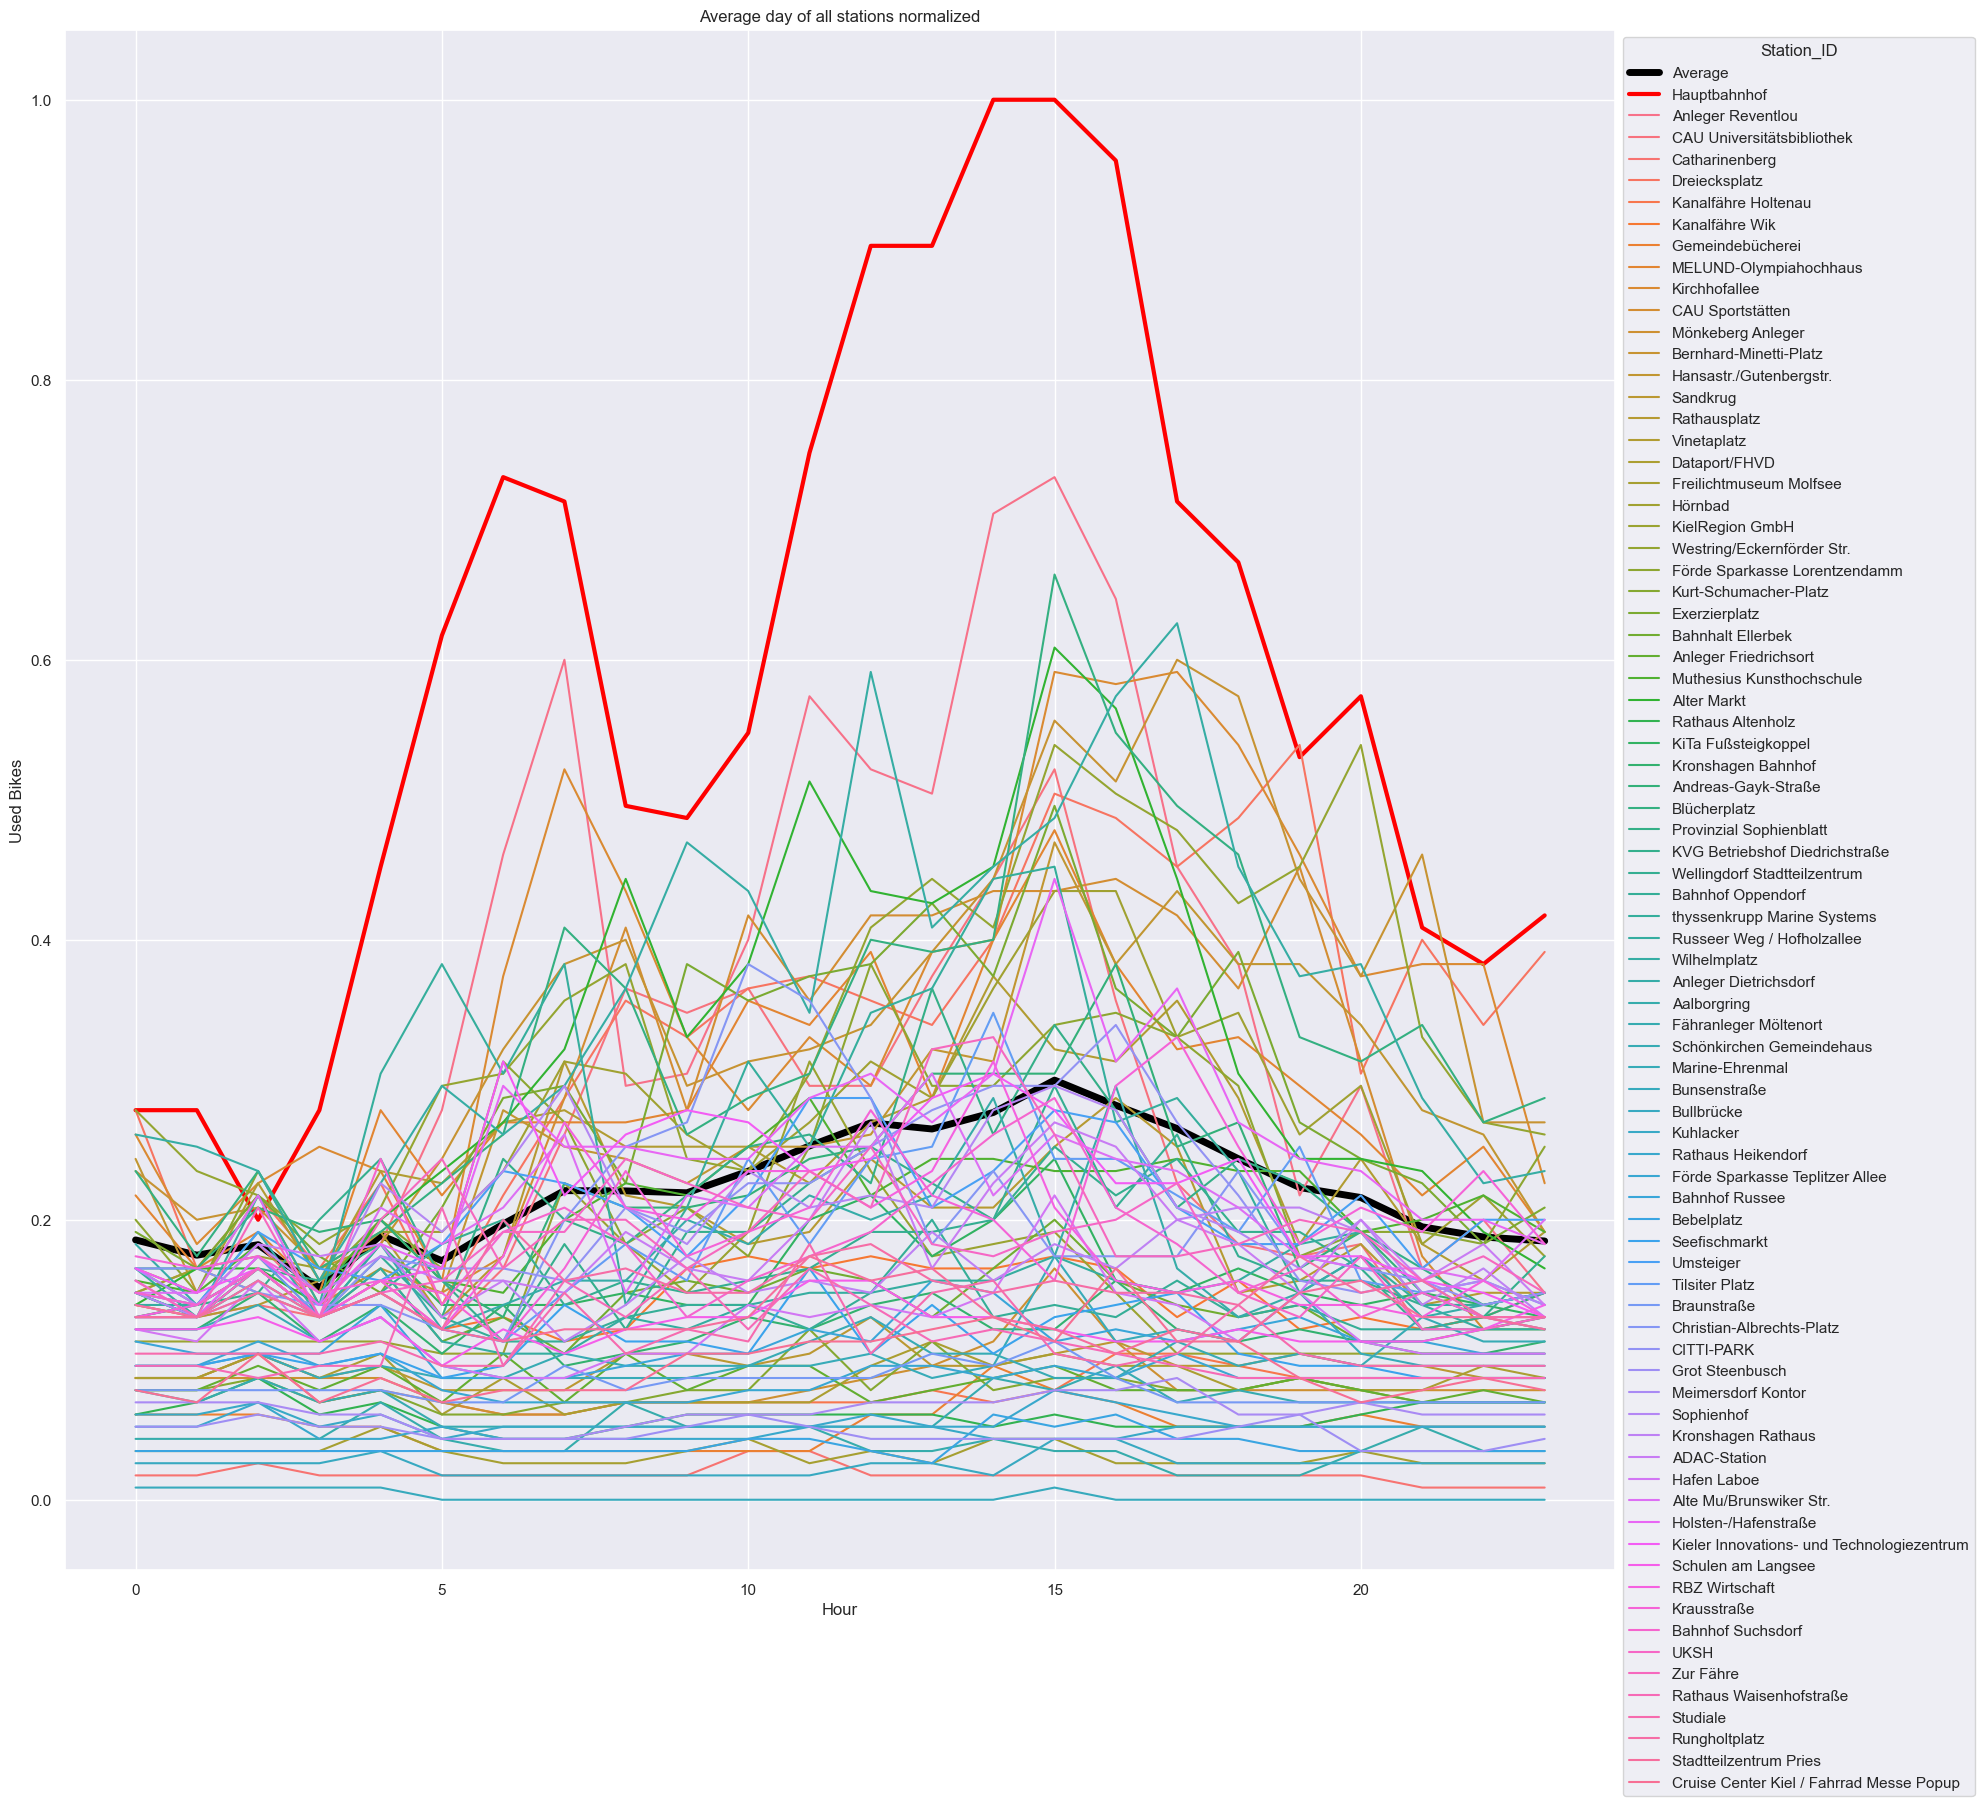

In [13]:
# Set the figure size and plot the graphs.
sns.set(rc={'figure.figsize':(20,20)})
plt = sns.lineplot(data=hour_avg_usage_df.query(f'Station_ID == "Average"'), x='Hour', y='Used Bikes', linewidth=5, color='black', label='Average')

# Highlight station 'Hauptbahnhof'.
if ('Hauptbahnhof' in list(hour_avg_usage_df['Station_ID'].unique())):  
    sns.lineplot(data=hour_avg_usage_df.query(f'Station_ID == "Hauptbahnhof"'), x='Hour', y='Used Bikes', linewidth=3, color='red', label='Hauptbahnhof')

sns.lineplot(data=hour_avg_usage_df.query(f'Station_ID not in ["Average", "Hauptbahnhof"]'), x='Hour', y='Used Bikes', hue='Station_ID')
plt.set(title='Average day of all stations normalized')
sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))


### Amplitude Scaling
Formula: x_i = (x_i - mean(x)) / std(x)

In [14]:
# Apply amplitude scaling on the graphs.

# List of all stations.
stations = list(hour_avg_usage_df['Station_ID'].unique())

# The resulting data frame.
ampl_sc_df = pd.DataFrame()

# Calculate the scaled values for every station and each hour.
for station in stations:
    station_df = hour_avg_usage_df.query(f'Station_ID == "{station}"')
    avg_values = list(station_df['Used Bikes'].values)
    mean = station_df['Used Bikes'].mean()
    std = station_df['Used Bikes'].std()
    scaled = []
    for i in range(0, len(avg_values)):
        # Formula for amplitude scaling.
        scaled.append((avg_values[i] - mean) / std)
    station_df['Used Bikes Scaled'] = scaled
    ampl_sc_df = pd.concat([ampl_sc_df, station_df])
    

In [15]:
# Normalize the 'Used Bikes Scaled' column.
scaler = MinMaxScaler()
ampl_sc_df['Used Bikes Scaled'] = (scaler.fit_transform(ampl_sc_df[['Used Bikes Scaled']]))
ampl_sc_df

Station_ID  Hour  Used Bikes  \
0                                      Average     0    0.185581   
1                                      Average     1    0.174684   
2                                      Average     2    0.182168   
3                                      Average     3    0.151348   
4                                      Average     4    0.188773   
...                                        ...   ...         ...   
1915  Cruise Center Kiel / Fahrrad Messe Popup    19    0.086957   
1916  Cruise Center Kiel / Fahrrad Messe Popup    20    0.069565   
1917  Cruise Center Kiel / Fahrrad Messe Popup    21    0.078261   
1918  Cruise Center Kiel / Fahrrad Messe Popup    22    0.086957   
1919  Cruise Center Kiel / Fahrrad Messe Popup    23    0.078261   

      Used Bikes Scaled  
0              0.203272  
1              0.156957  
2              0.188769  
3              0.057776  
4              0.216839  
...                 ...  
1915           0.288886  
1916           0.163732  
1917           0.226309  
1918           0.288886  
1919           0.226309  

[1920 rows x 4 columns]

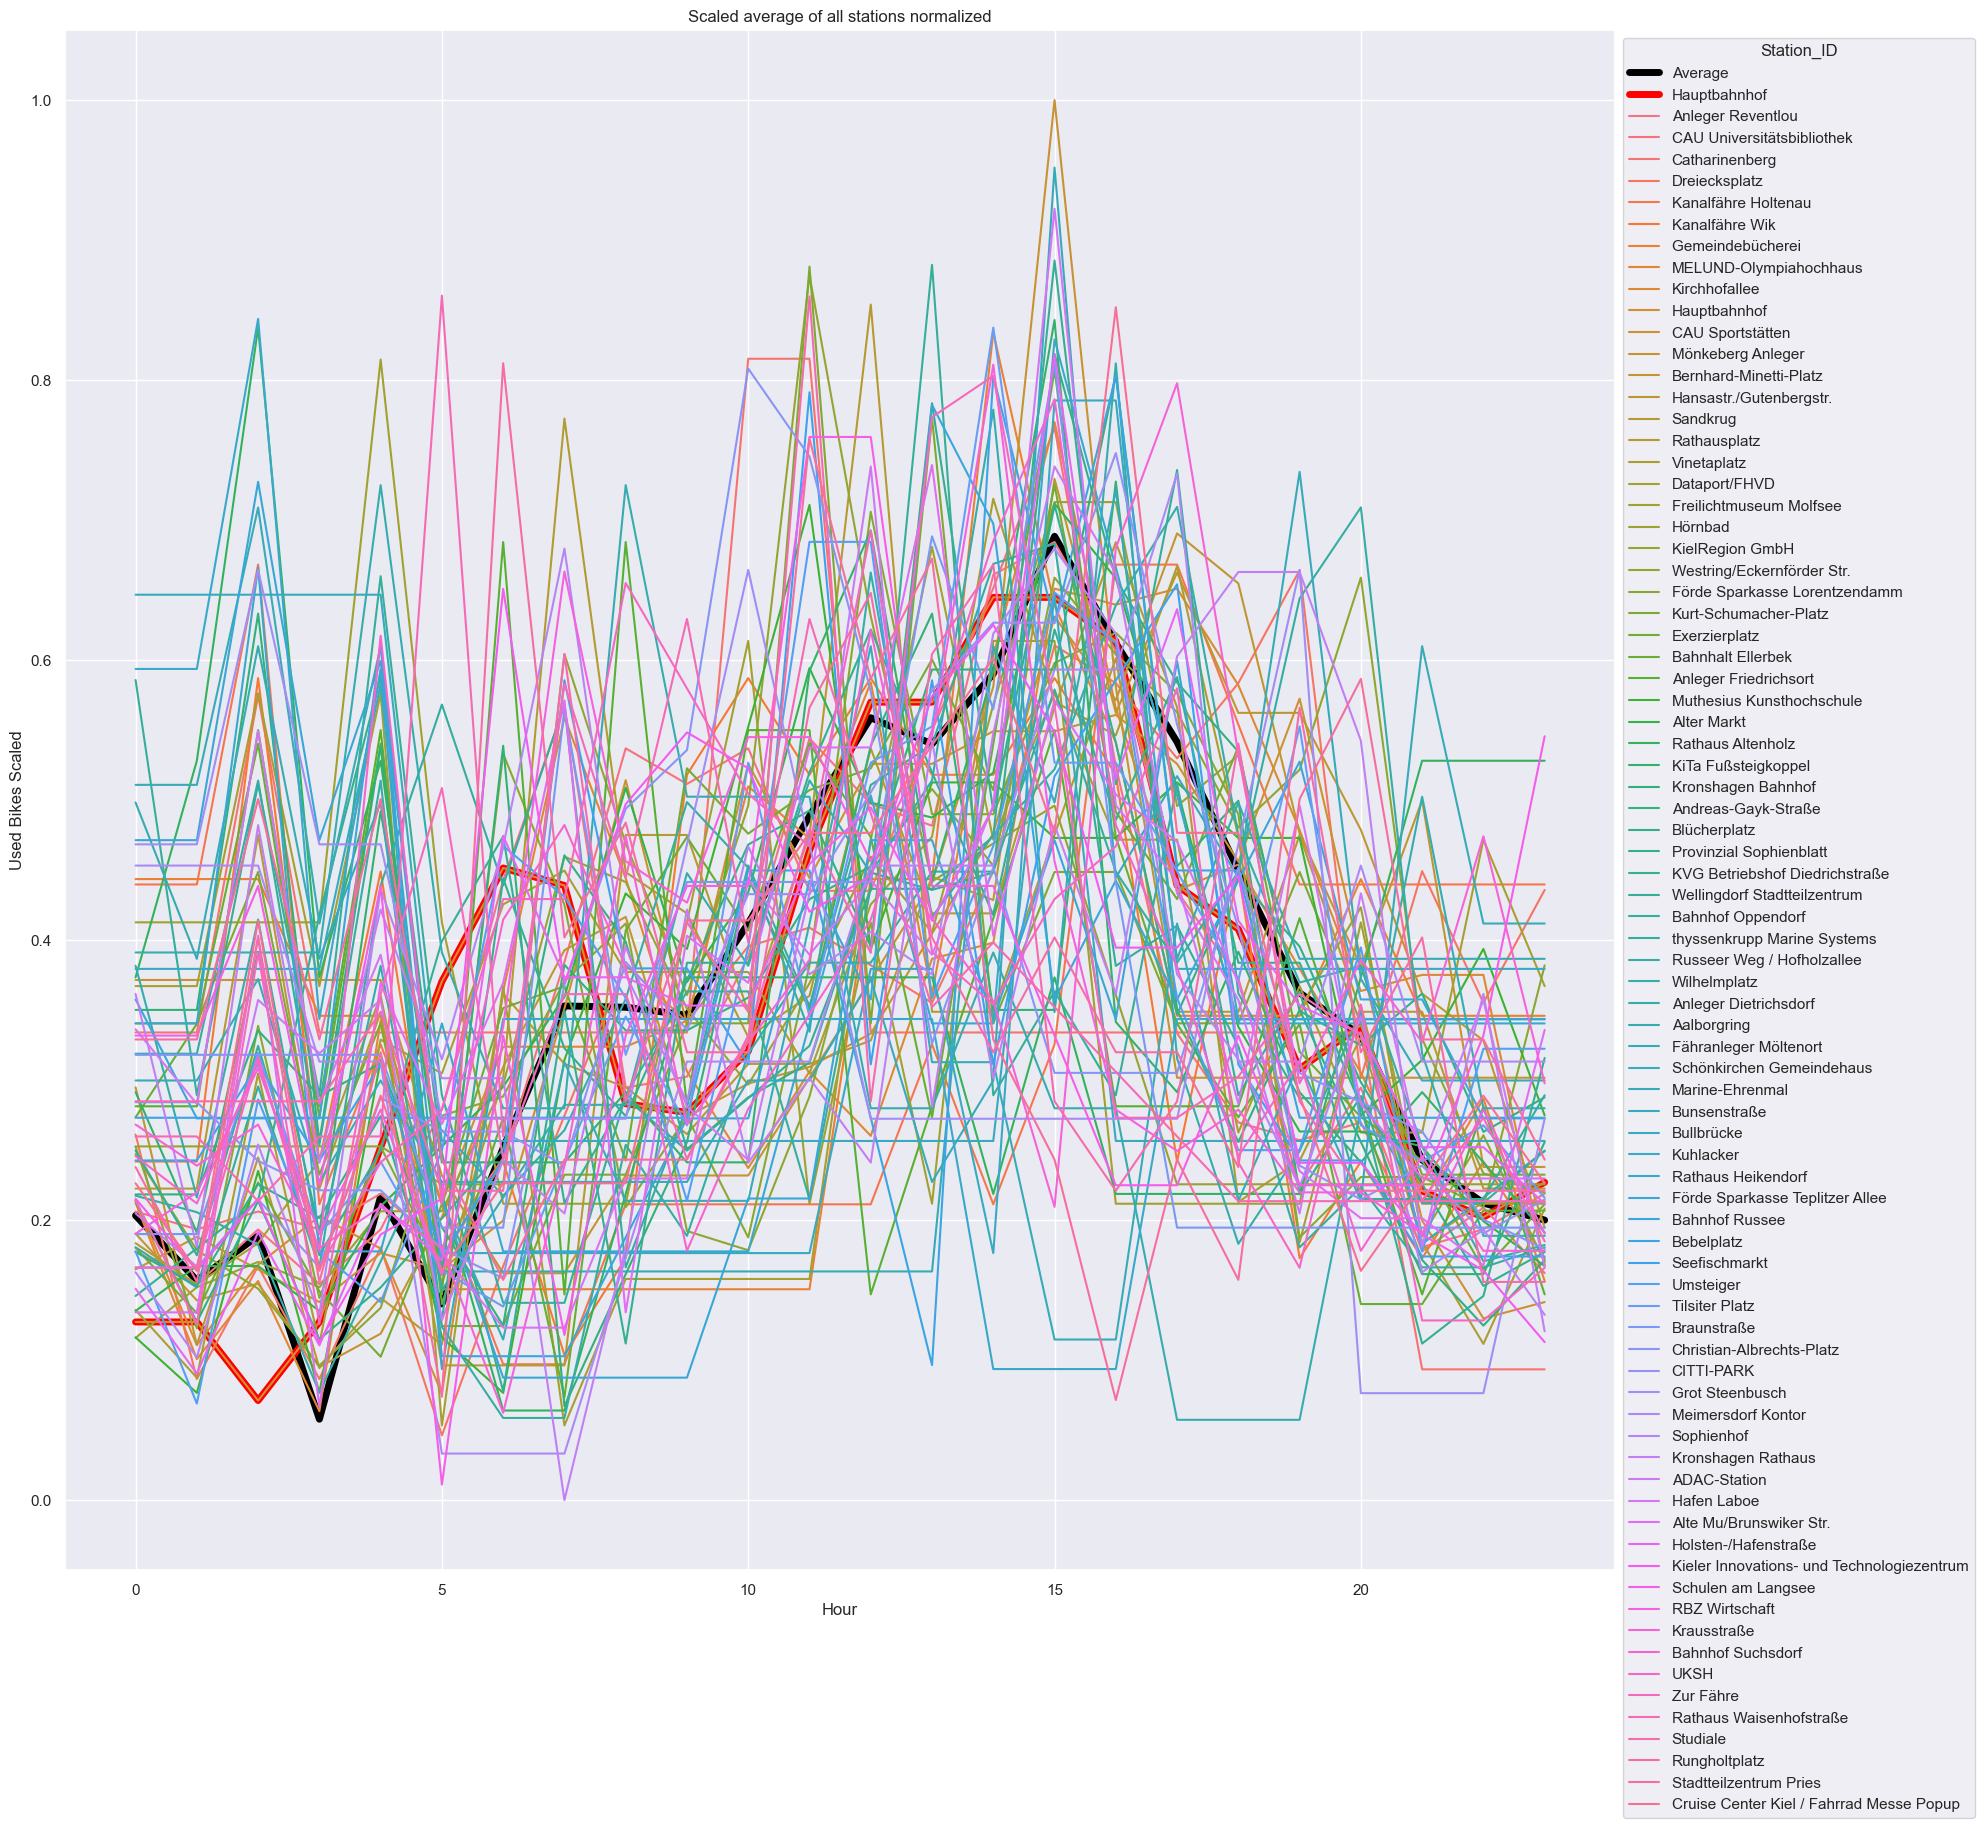

In [16]:
# Plot the scaled graphs.
sns.set(rc={'figure.figsize':(20,20)})
plt = sns.lineplot(data=ampl_sc_df.query(f'Station_ID == "Average"'), x='Hour', y='Used Bikes Scaled', linewidth=5, color='black', label='Average')

# Highlight station 'Hauptbahnhof'.
if ('Hauptbahnhof' in list(ampl_sc_df['Station_ID'].unique())): 
    sns.lineplot(data=ampl_sc_df.query(f'Station_ID == "Hauptbahnhof"'), x='Hour', y='Used Bikes Scaled', linewidth=5, color='red', label='Hauptbahnhof')

sns.lineplot(data=ampl_sc_df.query(f'Station_ID != "Average"'), x='Hour', y='Used Bikes Scaled', hue='Station_ID')

plt.set(title='Scaled average of all stations normalized')
sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))


### Calculate Global Extreme Values 

In [17]:
# Retrieve the extreme points of every plot.

# List of all stations.
stations = list(ampl_sc_df['Station_ID'].unique())

# Resulting data frame.
extr_pts_df = pd.DataFrame()

# Find global extreme points of every plot.
for station in stations:
    station_df = ampl_sc_df.query(f'Station_ID == "{station}"')
    
    # Global extreme values of current station.
    station_values = list(station_df['Used Bikes Scaled'].values)
    station_minimum_index = 0
    station_minimum = station_values[0]
    for i in range(len(station_values)):
        if station_values[i] < station_values[station_minimum_index]:
            station_minimum_index = i
            station_minimum = station_values[i]
            
    station_maximum_index = 0
    station_maximum = station_values[0]
    for i in range(len(station_values)):
        if station_values[i] > station_values[station_maximum_index]:
            station_maximum_index = i
            station_maximum = station_values[i]
            
    glob_min_list = [np.nan] * 24
    glob_min_list[station_minimum_index] = station_minimum
    glob_max_list = [np.nan] * 24
    glob_max_list[station_maximum_index] = station_maximum
    station_df['Global Minima'] = glob_min_list
    station_df['Global Maxima'] = glob_max_list
    extr_pts_df = pd.concat([extr_pts_df, station_df])
extr_pts_df



Station_ID  Hour  Used Bikes  \
0                                      Average     0    0.185581   
1                                      Average     1    0.174684   
2                                      Average     2    0.182168   
3                                      Average     3    0.151348   
4                                      Average     4    0.188773   
...                                        ...   ...         ...   
1915  Cruise Center Kiel / Fahrrad Messe Popup    19    0.086957   
1916  Cruise Center Kiel / Fahrrad Messe Popup    20    0.069565   
1917  Cruise Center Kiel / Fahrrad Messe Popup    21    0.078261   
1918  Cruise Center Kiel / Fahrrad Messe Popup    22    0.086957   
1919  Cruise Center Kiel / Fahrrad Messe Popup    23    0.078261   

      Used Bikes Scaled  Global Minima  Global Maxima  
0              0.203272            NaN            NaN  
1              0.156957            NaN            NaN  
2              0.188769            NaN            NaN  
3              0.057776       0.057776            NaN  
4              0.216839            NaN            NaN  
...                 ...            ...            ...  
1915           0.288886            NaN            NaN  
1916           0.163732            NaN            NaN  
1917           0.226309            NaN            NaN  
1918           0.288886            NaN            NaN  
1919           0.226309            NaN            NaN  

[1920 rows x 6 columns]

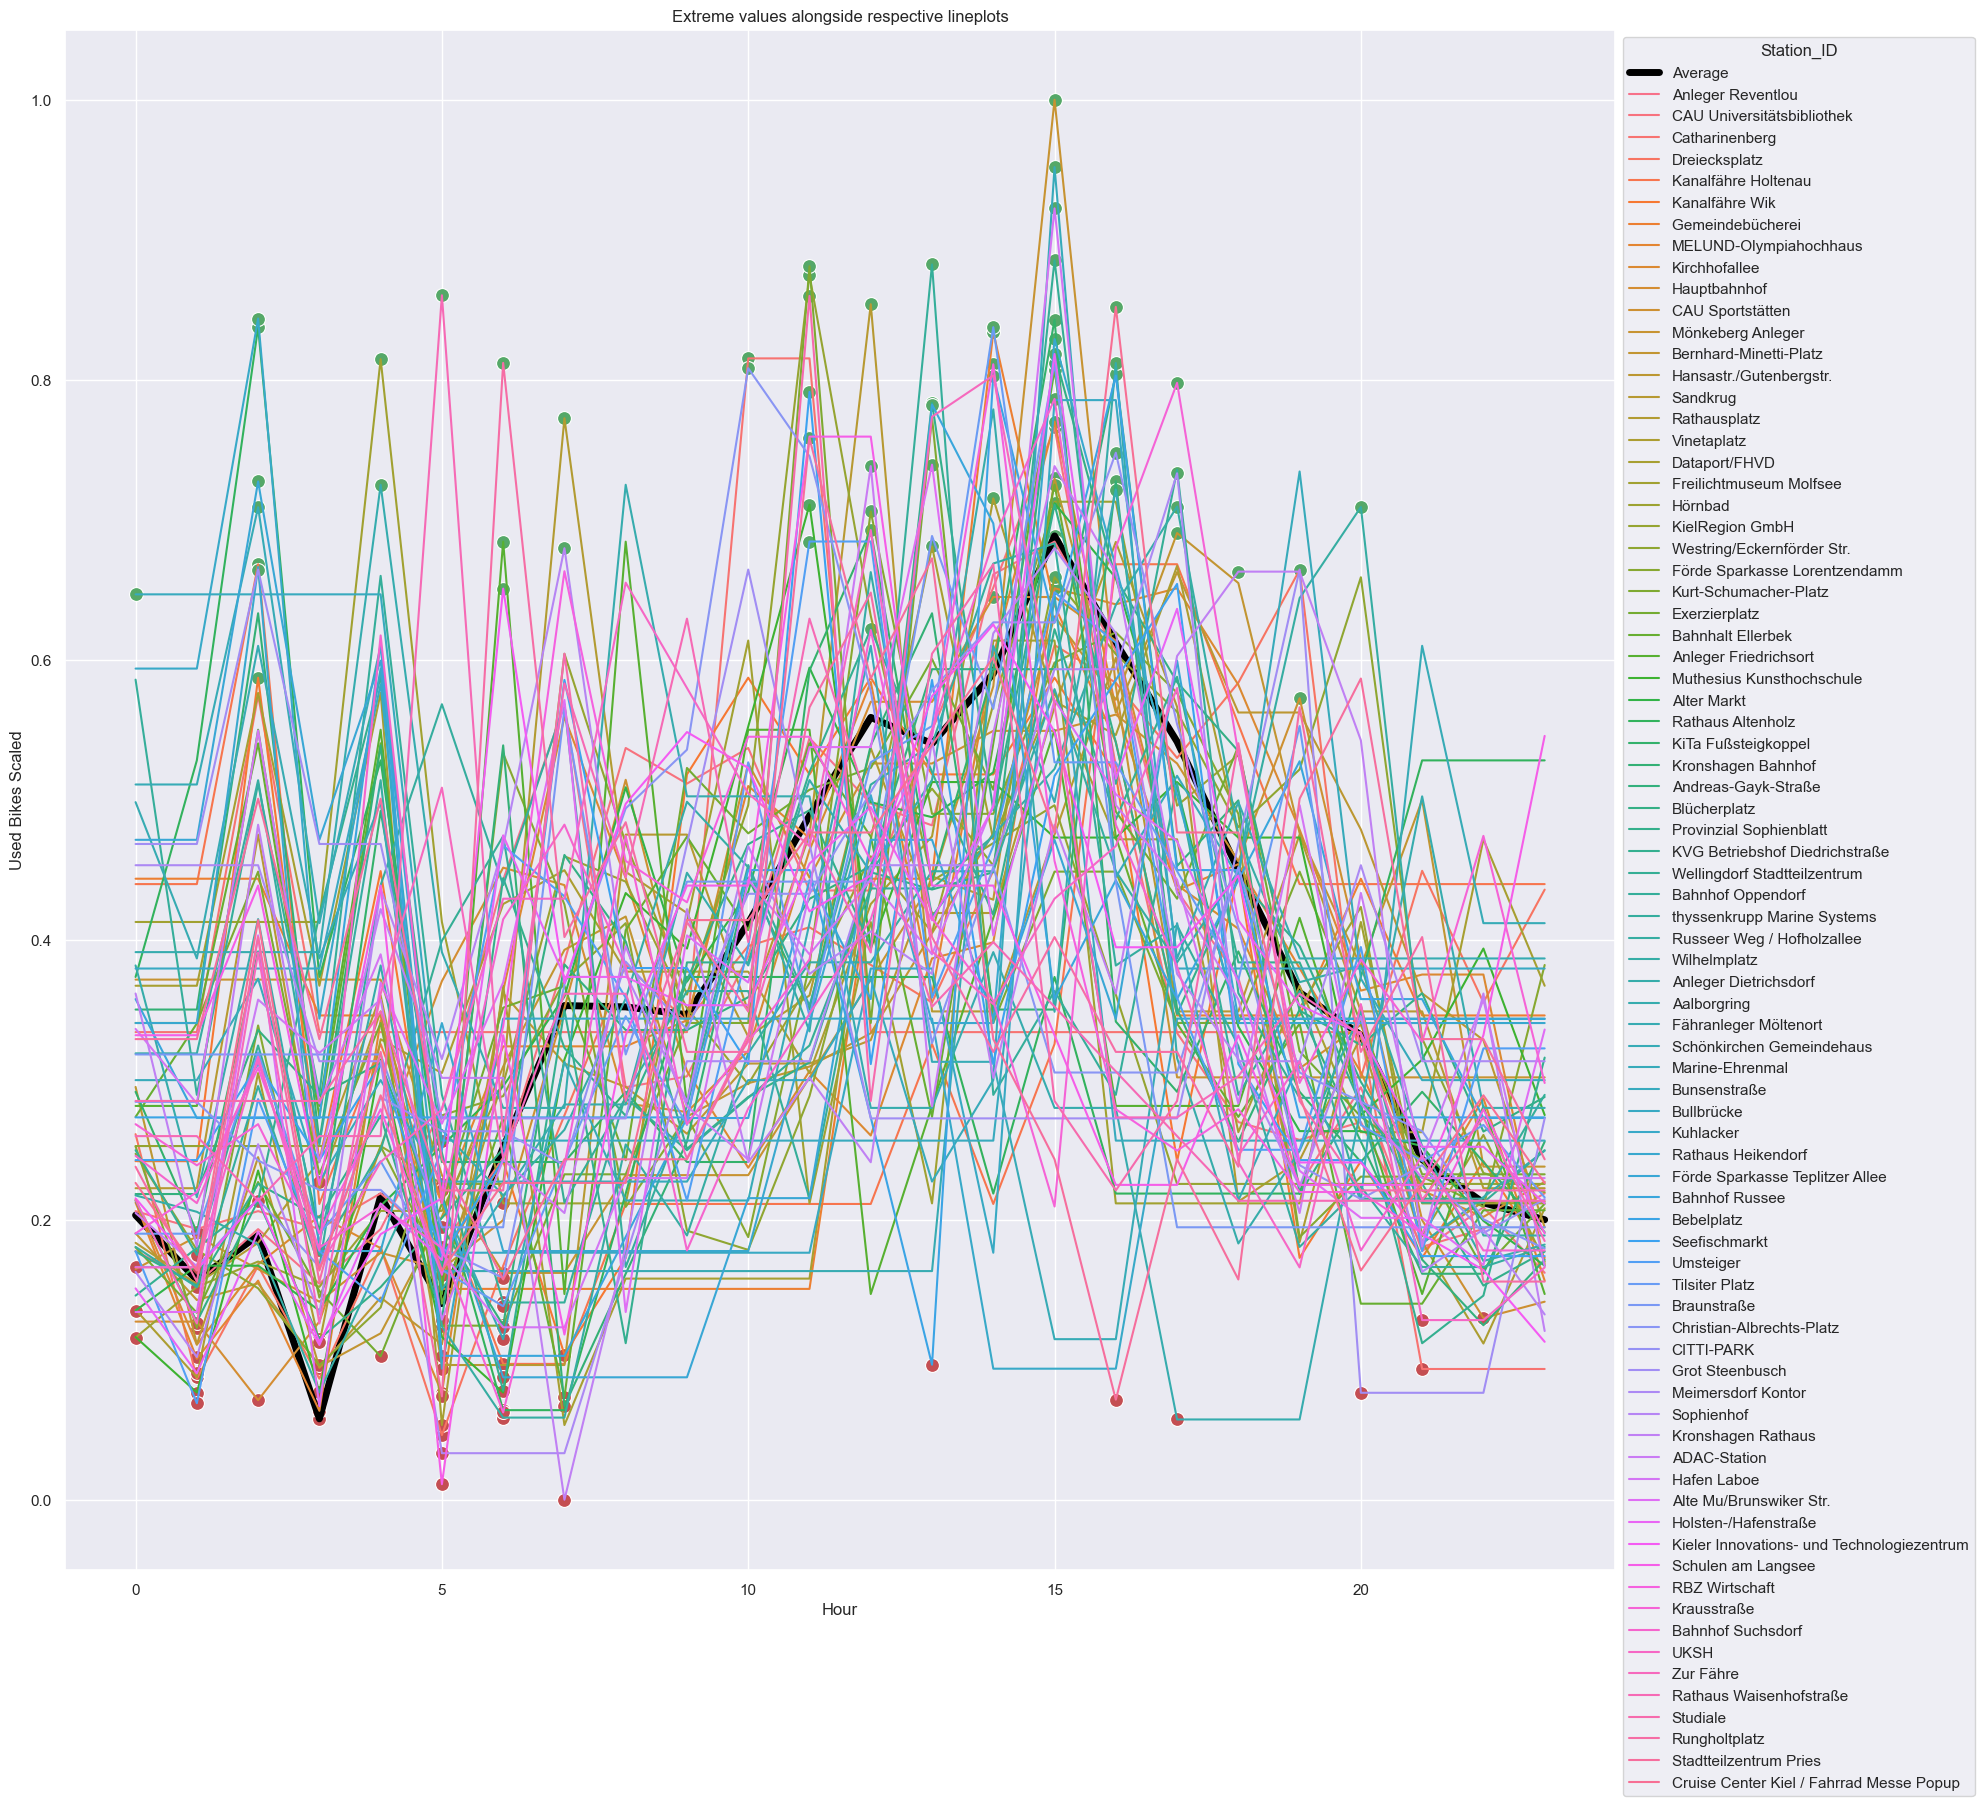

In [18]:
# Plot the extreme values alongside the respective lineplots.
sns.set(rc={'figure.figsize':(20,20)})
plt = sns.lineplot(data=extr_pts_df.query(f'Station_ID == "Average"'), x='Hour', y='Used Bikes Scaled', linewidth=5, color='black', label='Average')
sns.scatterplot(data=extr_pts_df, x='Hour', y='Global Minima', c='r', s=100)
sns.scatterplot(data=extr_pts_df, x='Hour', y='Global Maxima', c='g', s=100)
sns.lineplot(data=extr_pts_df.query(f'Station_ID != "Average"'), x='Hour', y='Used Bikes Scaled', hue='Station_ID')
plt.set(title='Extreme values alongside respective lineplots')
sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))

### Compute the gradients for each hour

In [19]:
def gradient(y1,y2):
    '''Returns the gradient between two points from one hour to the next one.'''
    
    return y2-y1

In [20]:
# Retrieve the gradients of every plot for each hour.

# List of stations.
stations = list(extr_pts_df['Station_ID'].unique())

# Resulting data frame.
gradient_df = pd.DataFrame()

# Compute hourly gradient for each plot.
for station in stations:
    station_df = extr_pts_df.query(f'Station_ID == "{station}"')
    avg_values = list(station_df['Used Bikes Scaled'].values)
    # Initial gradient is 0.
    avg_gradients = [0]
    # Compute gradient for each hour.
    for i in range(1, len(avg_values)):
        avg_gradients.append(gradient(avg_values[i-1], avg_values[i]))
    station_df['Gradient'] = avg_gradients
    gradient_df = pd.concat([gradient_df, station_df])
gradient_df


Station_ID  Hour  Used Bikes  \
0                                      Average     0    0.185581   
1                                      Average     1    0.174684   
2                                      Average     2    0.182168   
3                                      Average     3    0.151348   
4                                      Average     4    0.188773   
...                                        ...   ...         ...   
1915  Cruise Center Kiel / Fahrrad Messe Popup    19    0.086957   
1916  Cruise Center Kiel / Fahrrad Messe Popup    20    0.069565   
1917  Cruise Center Kiel / Fahrrad Messe Popup    21    0.078261   
1918  Cruise Center Kiel / Fahrrad Messe Popup    22    0.086957   
1919  Cruise Center Kiel / Fahrrad Messe Popup    23    0.078261   

      Used Bikes Scaled  Global Minima  Global Maxima  Gradient  
0              0.203272            NaN            NaN  0.000000  
1              0.156957            NaN            NaN -0.046316  
2              0.188769            NaN            NaN  0.031813  
3              0.057776       0.057776            NaN -0.130993  
4              0.216839            NaN            NaN  0.159064  
...                 ...            ...            ...       ...  
1915           0.288886            NaN            NaN -0.187731  
1916           0.163732            NaN            NaN -0.125154  
1917           0.226309            NaN            NaN  0.062577  
1918           0.288886            NaN            NaN  0.062577  
1919           0.226309            NaN            NaN -0.062577  

[1920 rows x 7 columns]

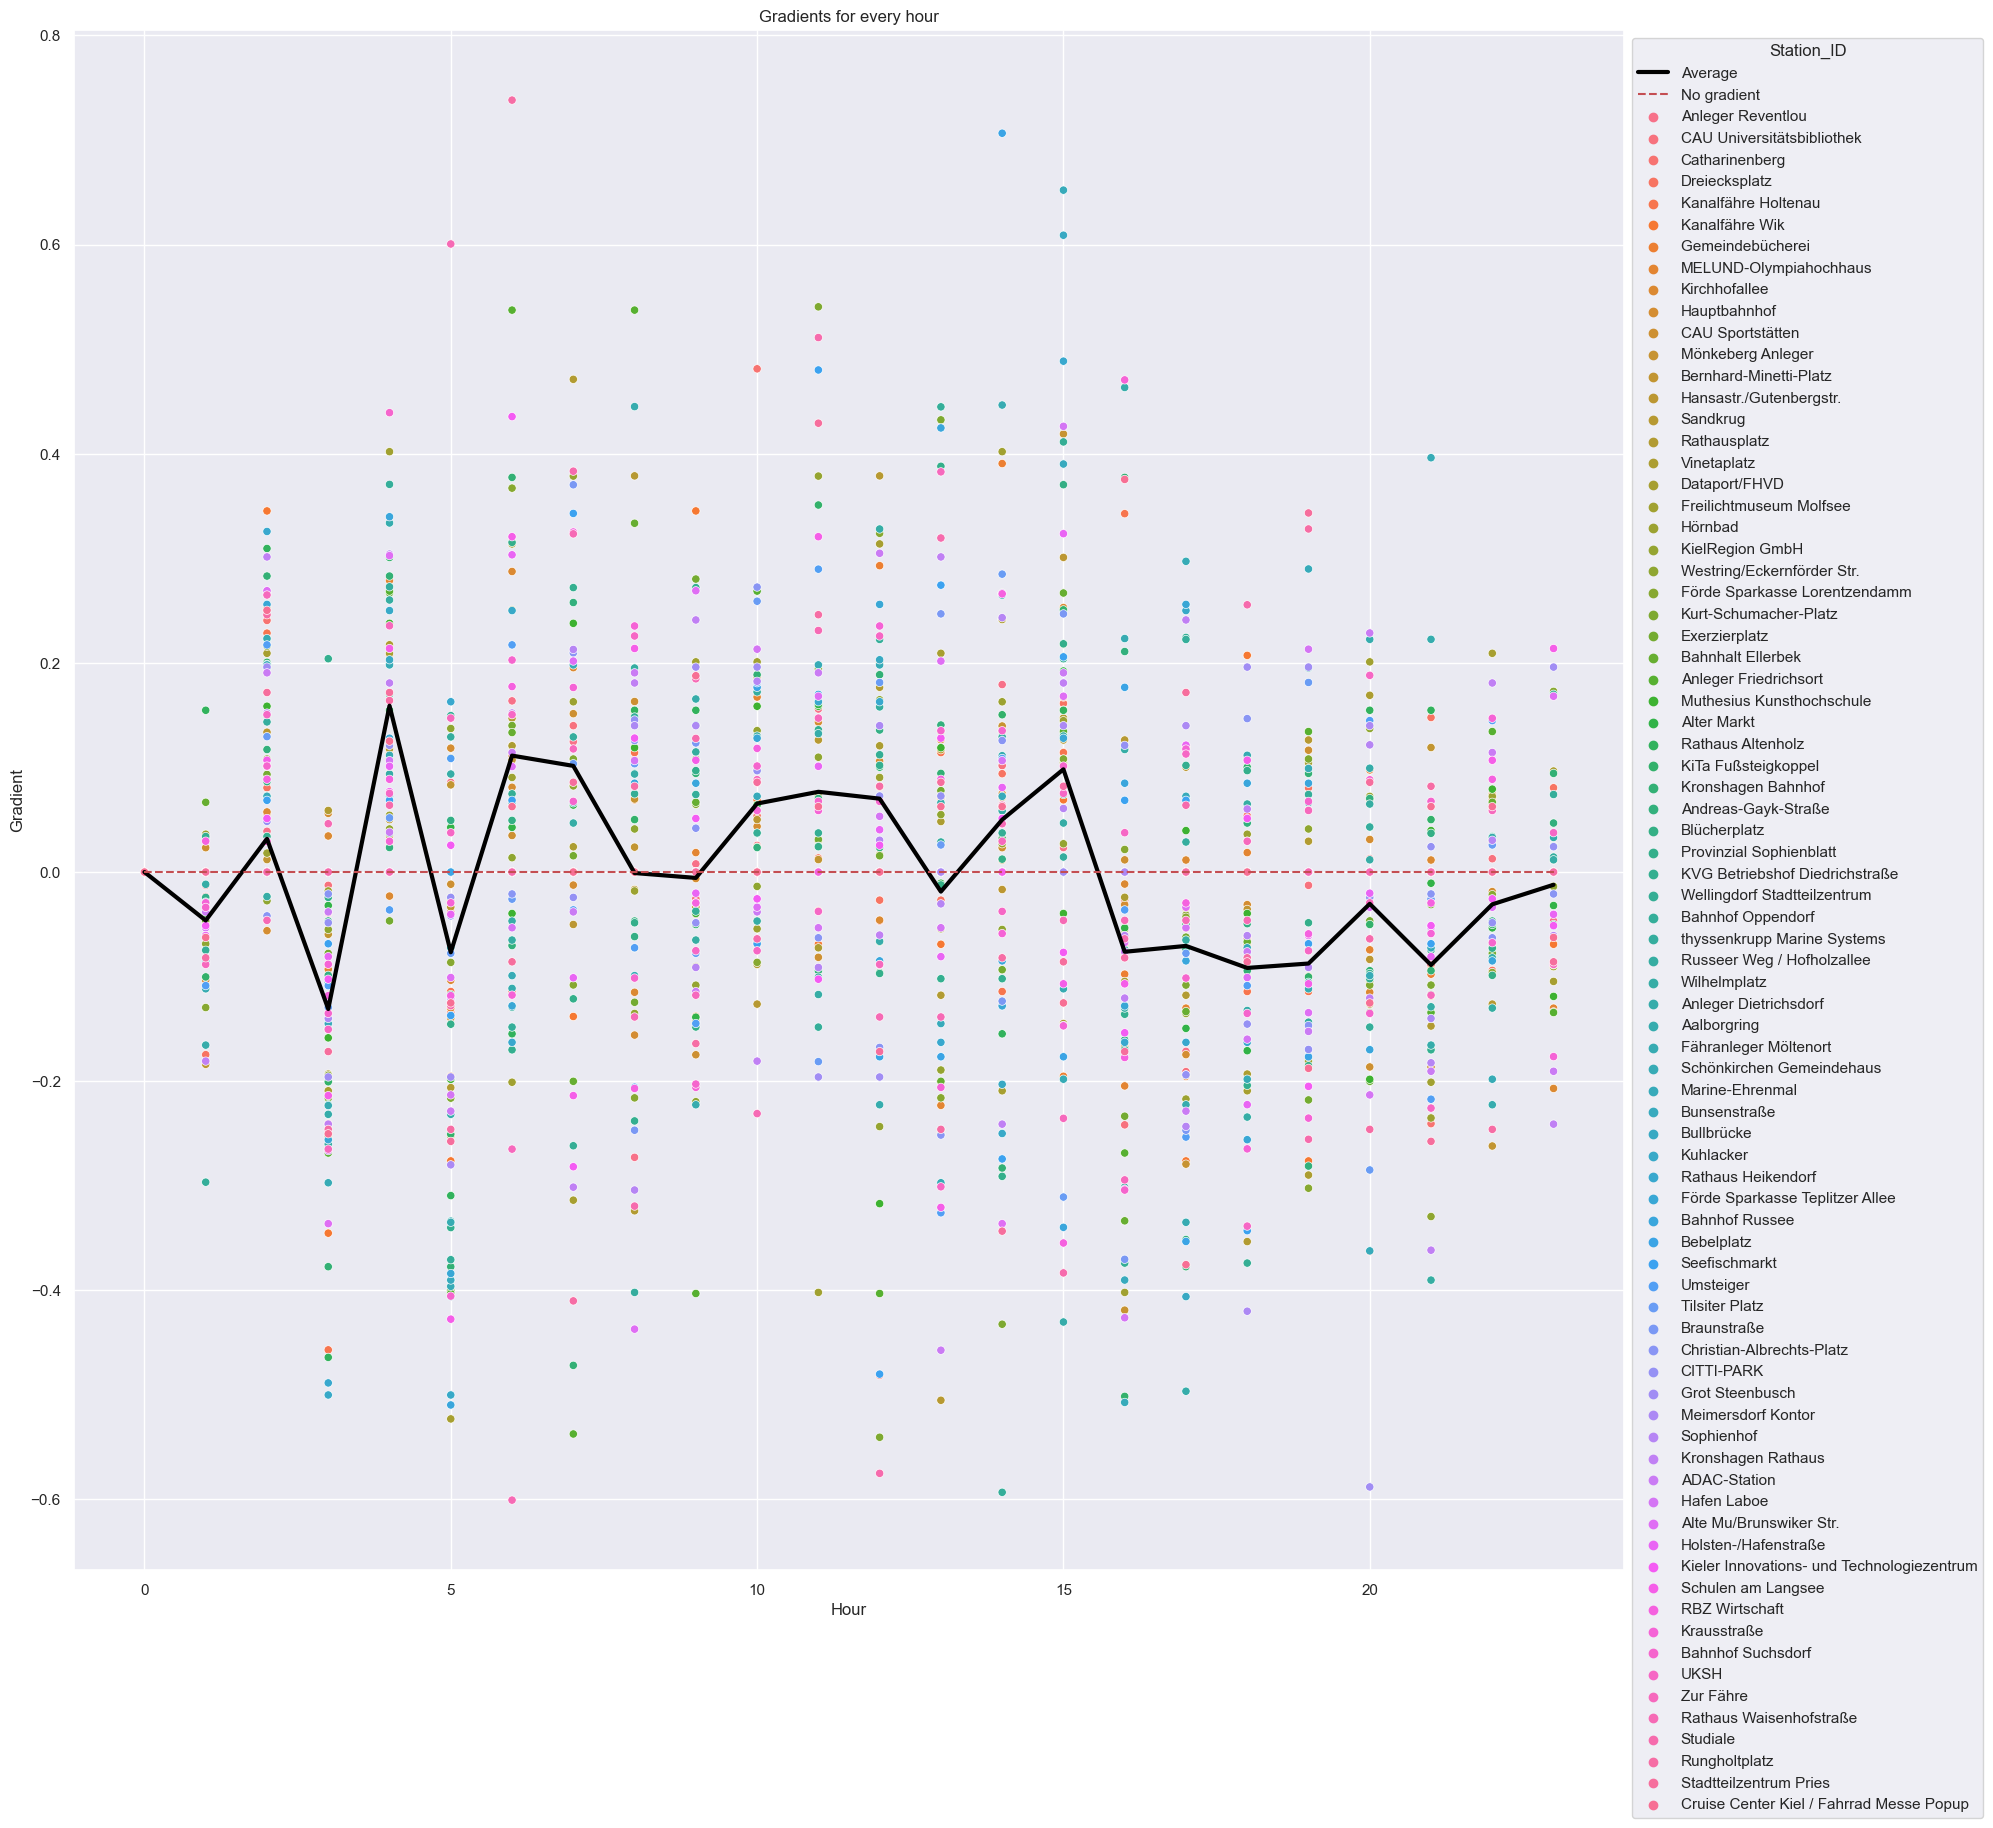

In [21]:
# Plot the gradients.
sns.set(rc={'figure.figsize':(20,20)})
plt = sns.lineplot(data=gradient_df.query(f'Station_ID == "Average"'), x='Hour', y='Gradient', linewidth=3, color='black', label='Average')
sns.lineplot(x=list(range(24)), y=24*[0], color='r', linestyle='--', label='No gradient')
sns.scatterplot(data=gradient_df.query(f'Station_ID != "Average"'), x='Hour', y='Gradient', hue='Station_ID')
plt.set(title='Gradients for every hour')
sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))

### Outlier Detection and Visualization

In [22]:
def convert_not_NaN(value):
    '''Converts a not NaN value to 1.'''
    
    if (not math.isnan(value)):
        return 1

In [23]:
# Declare our data frame with all attributes so far calculated.
all_attr_df = gradient_df.copy().set_index('Station_ID')

# Convert the columns 'Local Minima' and 'Local Maxima' so that extreme values are represented by 1 and the other values are represented by 0.
all_attr_df['Global Minima Marked'] = all_attr_df['Global Minima']
all_attr_df['Global Minima Marked'] = all_attr_df['Global Minima Marked'].apply(convert_not_NaN)
all_attr_df['Global Minima Marked'] = all_attr_df['Global Minima Marked'].fillna(0)
all_attr_df['Global Maxima Marked'] = all_attr_df['Global Maxima']
all_attr_df['Global Maxima Marked'] = all_attr_df['Global Maxima Marked'].apply(convert_not_NaN)
all_attr_df['Global Maxima Marked'] = all_attr_df['Global Maxima Marked'].fillna(0)

all_attr_df

Hour  Used Bikes  Used Bikes Scaled  \
Station_ID                                                                      
Average                                      0    0.185581           0.203272   
Average                                      1    0.174684           0.156957   
Average                                      2    0.182168           0.188769   
Average                                      3    0.151348           0.057776   
Average                                      4    0.188773           0.216839   
...                                        ...         ...                ...   
Cruise Center Kiel / Fahrrad Messe Popup    19    0.086957           0.288886   
Cruise Center Kiel / Fahrrad Messe Popup    20    0.069565           0.163732   
Cruise Center Kiel / Fahrrad Messe Popup    21    0.078261           0.226309   
Cruise Center Kiel / Fahrrad Messe Popup    22    0.086957           0.288886   
Cruise Center Kiel / Fahrrad Messe Popup    23    0.078261           0.226309   

                                          Global Minima  Global Maxima  \
Station_ID                                                               
Average                                             NaN            NaN   
Average                                             NaN            NaN   
Average                                             NaN            NaN   
Average                                        0.057776            NaN   
Average                                             NaN            NaN   
...                                                 ...            ...   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   

                                          Gradient  Global Minima Marked  \
Station_ID                                                                 
Average                                   0.000000                   0.0   
Average                                  -0.046316                   0.0   
Average                                   0.031813                   0.0   
Average                                  -0.130993                   1.0   
Average                                   0.159064                   0.0   
...                                            ...                   ...   
Cruise Center Kiel / Fahrrad Messe Popup -0.187731                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup -0.125154                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup  0.062577                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup  0.062577                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup -0.062577                   0.0   

                                          Global Maxima Marked  
Station_ID                                                      
Average                                                    0.0  
Average                                                    0.0  
Average                                                    0.0  
Average                                                    0.0  
Average                                                    0.0  
...                                                        ...  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0  

[1920 rows x 8 columns]

#### Outlier Detection 'By Hand'

In [48]:
# List of stations.
stations = list(all_attr_df.index.unique())

# Resulting data frame.
self_outlier_df = pd.DataFrame()

# For every hour find the stations whose usage differs strongly from the average usage. 
for station in stations:
    # Data frame, values, gradients and extreme values of 'Average' station. 
    avg_df = all_attr_df.query(f'Station_ID == "Average"')
    avg_values = list(avg_df['Used Bikes Scaled'].values)
    avg_gradients = list(avg_df['Gradient'].values)
    select_not_NaN = avg_df[avg_df['Global Minima'].notnull()]
    avg_minimum_index = select_not_NaN['Hour'].iloc[0]
    avg_minimum_index_range = list(range(avg_minimum_index - 6, avg_minimum_index + 6))
    avg_minimum_index_range = list(map(lambda x : x % 24, avg_minimum_index_range))
    select_not_NaN = avg_df[avg_df['Global Maxima'].notnull()]
    avg_maximum_index = select_not_NaN['Hour'].iloc[0]
    avg_maximum_index_range = list(range(avg_maximum_index - 6, avg_maximum_index + 6))
    avg_maximum_index_range = list(map(lambda x : x % 24, avg_maximum_index_range))
    
    # Data frame, values, gradients and extreme values of current station.
    station_df = all_attr_df.query(f'Station_ID == "{station}"')
    station_values = list(station_df['Used Bikes Scaled'].values)
    station_gradients = list(station_df['Gradient'].values)
    select_not_NaN = station_df[station_df['Global Minima'].notnull()]
    station_minimum_index = select_not_NaN['Hour'].iloc[0]
    select_not_NaN = station_df[station_df['Global Maxima'].notnull()]
    station_maximum_index = select_not_NaN['Hour'].iloc[0]
    
    # List of outliers.
    is_outlier = []
    # For every hour find outliers.
    for i in range(0, len(avg_values)):
        # Outlier conditions.
        
        # Initially no outlier.
        outlier = 0
        
        # Usage differs strongly at this hour.
        if (abs(avg_values[i] - station_values[i]) > 0.5):
            print('Usage of', station, 'differs at hour', i)
            outlier = 1
        
        # Gradient differs strongly at this hour.
        if (abs(avg_gradients[i] - station_gradients[i]) > 0.5):
            print('Gradient of', station, 'differs at hour', i)
            outlier = 1
            
        # Station curve has different global minimum than average.
        if i == station_minimum_index:
            if (avg_minimum_index != station_minimum_index):
                # Check if avgerage minimum is close to this hour. If not, the outlier condition is met.
                if(not station_minimum_index in avg_minimum_index_range):
                    print('Minimum of', station, 'is at hour', station_minimum_index)
                    outlier = 1
        
        # Station curve has different global maximum than average.
        if i == station_maximum_index:
            if (avg_maximum_index != station_maximum_index):
                # Check if avgerage maximum is close to this hour. If not, the outlier condition is met.
                if(not station_maximum_index in avg_maximum_index_range):
                    print('Maximum of', station, 'is at hour', station_maximum_index)
                    outlier = 1
            
        is_outlier.append(outlier)
    station_df['Outlier'] = is_outlier
    self_outlier_df = pd.concat([self_outlier_df, station_df])
    
self_outlier_df

Gradient of Catharinenberg differs at hour 12
Maximum of Kanalfähre Holtenau is at hour 2
Maximum of Kanalfähre Wik is at hour 2
Maximum of Rathausplatz is at hour 7
Usage of Freilichtmuseum Molfsee differs at hour 4
Maximum of Freilichtmuseum Molfsee is at hour 4
Gradient of Kurt-Schumacher-Platz differs at hour 12
Maximum of Anleger Friedrichsort is at hour 6
Gradient of Anleger Friedrichsort differs at hour 7
Gradient of Anleger Friedrichsort differs at hour 8
Usage of Rathaus Altenholz differs at hour 2
Maximum of Rathaus Altenholz is at hour 2
Gradient of Kronshagen Bahnhof differs at hour 7
Gradient of Bahnhof Oppendorf differs at hour 14
Gradient of Anleger Dietrichsdorf differs at hour 15
Gradient of Anleger Dietrichsdorf differs at hour 16
Usage of Aalborgring differs at hour 4
Maximum of Aalborgring is at hour 4
Minimum of Aalborgring is at hour 17
Usage of Schönkirchen Gemeindehaus differs at hour 2
Maximum of Schönkirchen Gemeindehaus is at hour 2
Usage of Schönkirchen Geme

Hour  Used Bikes  Used Bikes Scaled  \
Station_ID                                                                      
Average                                      0    0.185581           0.203272   
Average                                      1    0.174684           0.156957   
Average                                      2    0.182168           0.188769   
Average                                      3    0.151348           0.057776   
Average                                      4    0.188773           0.216839   
...                                        ...         ...                ...   
Cruise Center Kiel / Fahrrad Messe Popup    19    0.086957           0.288886   
Cruise Center Kiel / Fahrrad Messe Popup    20    0.069565           0.163732   
Cruise Center Kiel / Fahrrad Messe Popup    21    0.078261           0.226309   
Cruise Center Kiel / Fahrrad Messe Popup    22    0.086957           0.288886   
Cruise Center Kiel / Fahrrad Messe Popup    23    0.078261           0.226309   

                                          Global Minima  Global Maxima  \
Station_ID                                                               
Average                                             NaN            NaN   
Average                                             NaN            NaN   
Average                                             NaN            NaN   
Average                                        0.057776            NaN   
Average                                             NaN            NaN   
...                                                 ...            ...   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   
Cruise Center Kiel / Fahrrad Messe Popup            NaN            NaN   

                                          Gradient  Global Minima Marked  \
Station_ID                                                                 
Average                                   0.000000                   0.0   
Average                                  -0.046316                   0.0   
Average                                   0.031813                   0.0   
Average                                  -0.130993                   1.0   
Average                                   0.159064                   0.0   
...                                            ...                   ...   
Cruise Center Kiel / Fahrrad Messe Popup -0.187731                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup -0.125154                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup  0.062577                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup  0.062577                   0.0   
Cruise Center Kiel / Fahrrad Messe Popup -0.062577                   0.0   

                                          Global Maxima Marked  Outlier  
Station_ID                                                               
Average                                                    0.0        0  
Average                                                    0.0        0  
Average                                                    0.0        0  
Average                                                    0.0        0  
Average                                                    0.0        0  
...                                                        ...      ...  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0        0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0        0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0        0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0        0  
Cruise Center Kiel / Fahrrad Messe Popup                   0.0        0  

[1920 rows x 9 columns]

##### Save data for usage in the website, if changed.

In [53]:
# Change the hour format for usage in the website.
# self_outlier_df['Hour'] = self_outlier_df['Hour'].apply((lambda x : str(x) + ':00'))

# Save the collected data for usage in the website.
# indexed = self_outlier_df.reset_index()
# indexed.to_json("./web_application/src/data/self_outlier_df.json")

##### Count for how many hours a station is an outlier on the whole day

In [49]:
# Selecting rows based on outlier condition.
self_outlier_selected_df = self_outlier_df[self_outlier_df['Outlier'] == 1]

# Selecting stations based on outlier condition.
self_outlier_stations = list(self_outlier_selected_df.index.unique())

# Count for how many hours a station is an outlier on the whole day.
self_outlier_stations_dict = {}
for station in self_outlier_stations:
    self_outlier_station_df = self_outlier_selected_df.query(f'Station_ID == "{station}"')
    self_outlier_count = len(self_outlier_station_df)
    self_outlier_stations_dict[station] = self_outlier_count
self_outlier_stations_dict

{'Catharinenberg': 1,
 'Kanalfähre Holtenau': 1,
 'Kanalfähre Wik': 1,
 'Rathausplatz': 1,
 'Freilichtmuseum Molfsee': 1,
 'Kurt-Schumacher-Platz': 1,
 'Anleger Friedrichsort': 3,
 'Rathaus Altenholz': 1,
 'Kronshagen Bahnhof': 1,
 'Bahnhof Oppendorf': 1,
 'Anleger Dietrichsdorf': 2,
 'Aalborgring': 2,
 'Schönkirchen Gemeindehaus': 2,
 'Marine-Ehrenmal': 1,
 'Bunsenstraße': 2,
 'Bullbrücke': 1,
 'Kuhlacker': 3,
 'Förde Sparkasse Teplitzer Allee': 1,
 'Bebelplatz': 2,
 'Seefischmarkt': 1,
 'Grot Steenbusch': 2,
 'Sophienhof': 1,
 'Kieler Innovations- und Technologiezentrum': 1,
 'Krausstraße': 1,
 'Rathaus Waisenhofstraße': 2,
 'Studiale': 1,
 'Rungholtplatz': 2,
 'Stadtteilzentrum Pries': 1}

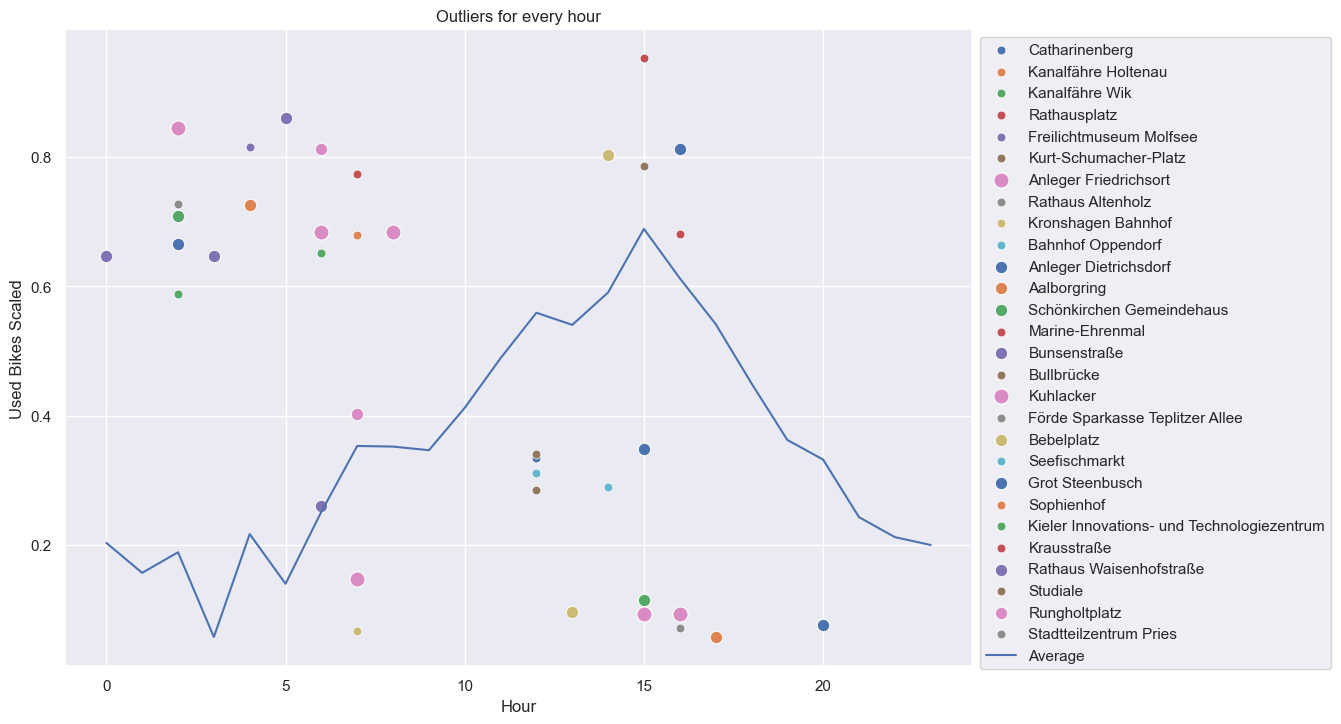

In [50]:
# Plot the outliers in comparison to the average usage.
sns.set(rc={'figure.figsize':(11.7,8.27)})
for station in self_outlier_stations:
    sns.scatterplot(data=self_outlier_selected_df.query(f'Station_ID == "{station}"'), x='Hour', y='Used Bikes Scaled', label=station, s=40*self_outlier_stations_dict[station])
plt = sns.lineplot(data=self_outlier_df.query(f'Station_ID == "Average"'), x='Hour', y='Used Bikes Scaled', label='Average')
plt.set(title='Outliers for every hour')
sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))